In [1]:
from typing import Annotated, List
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

/Users/shauryamacbook/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
class State(TypedDict):
    messages:Annotated[List, "List of messages in the conversation"]
    # messages: List[Dict[str, Any]]
    # user_input: str
    # response: str

graph_builder = StateGraph(State)

In [3]:
graph_builder

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct", temperature=0.0)
# llm = init_chat_model("groq:meta-llama/llama-4-scout-17b-16e-instruct", temperature=0.0)
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x1281835e0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x1281a7be0>, model_name='meta-llama/llama-4-scout-17b-16e-instruct', temperature=1e-08, model_kwargs={}, groq_api_key=SecretStr('**********'))

In [6]:
# Node Functionality
def chatbot(state: State) -> State:
    return {"messages":[llm.invoke(state["messages"])]}

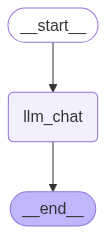

In [7]:
# Adding Nodes
graph_builder.add_node("llm_chat", chatbot)

## Adding Edges
graph_builder.add_edge(START, "llm_chat")
graph_builder.add_edge("llm_chat", END)

## compile the graph
graph = graph_builder.compile()
graph_builder.compile()

In [8]:
# from IPython.display import display, Image, Markdown

# try:
#     display(Image(graph.get_graph().draw_mermaid_png()))
# except Exception:
#     None

In [9]:
response = graph.invoke({"messages": "Hi, I am Shaurya"})  # Example invocation with an empty message list

In [10]:
response["messages"][-1].content

"Hi Shaurya! It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [11]:
for event in graph.stream({"messages": "Hello, who are you?"}):
    for value in event.values():
        print(value["messages"][-1].content)


I'm an AI assistant designed by Meta. I'm here to answer your questions, share interesting ideas and maybe even surprise you with a fresh perspective. What's on your mind?


In [12]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tool.invoke("What is the capital of India?")

{'query': 'What is the capital of India?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.usatoday.com/story/news/world/2023/05/24/what-is-the-capital-of-india/70195720007/',
   'title': 'What is the capital of India? States and union territories ...',
   'content': 'The capital of India is New Delhi, located in the north-central part of the country to the west of the Yamuna River.',
   'score': 0.9302622,
   'raw_content': None},
  {'url': 'https://www.doubtnut.com/qna/649225313',
   'title': 'What is the capital of India?',
   'content': '# What is the capital of India? ## Delhi is the capital of India. * WHICH IS THE NATIONAL CAPITAL OF INDIA * The financial capital of India is called- * भारत की राजधानी कहाँ है? * What was the capital of the French colony in India? * When was Delhi declared as the capital of India? * भारत में फ्रांसीसी उपनिवेश की राजधानी क्या थी? * भारत में फ्रांसीसी उपनिवेश की राजधानी क्या थी? 1. What is the capital 

# Custom Tool

In [13]:
def multiply(a:int, b:int) -> int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """

In [14]:
tools = [tool, multiply]

In [15]:
llm_with_tools = llm.bind_tools(tools)

In [16]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x1281835e0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x1281a7be0>, model_name='meta-llama/llama-4-scout-17b-16e-instruct', temperature=1e-08, model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'defau

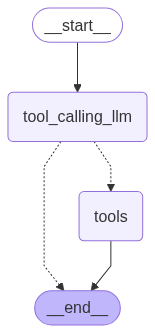

In [17]:
## New State Graph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state['messages'])]}

## Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

## Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)

builder.add_edge("tools", END)

## Compile the graph
graph = builder.compile()
builder.compile()

In [18]:
tool_response = graph.invoke({"messages": ["what is the recent ai news"]})  # Example invocation with an empty message list
# tool_response["messages"][-1].content

for m in tool_response["messages"]:
    m.pretty_print()

================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.csoonline.com/article/4042627/nists-attempts-to-secure-ai-yields-many-questions-no-answers.html", "title": "NIST’s attempts to secure AI yield many questions, no answers - csoonline.com", "score": 0.72348577, "published_date": "Wed, 20 Aug 2025 02:52:38 GMT", "content": "### GitHub package limit put law firm in security bind\n\n  May 21, 2025 5 mins\n news\n\n  ### Microsoft OneDrive move may facilitate accidental sensitive file exfiltration\n\n  May 9, 2025 8 mins\n news\n\n  ### Microsoft appoints Deputy CISO for Europe to reassure European IT leaders\n\n  May 1, 2025 4 mins\n\n## Show me more\n\nnews\n\n### NIST’s attempts to secure AI yield many questions, no answers\n\nBy Evan Schuman\n\nAug 19, 20259 mins\n\nArtificial IntelligenceGenerative AISecurity\n\nnews",

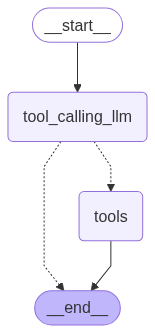

In [19]:
## New State Graph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state['messages'])]}

## Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

## Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)

builder.add_edge("tools", END)

## Compile the graph
graph = builder.compile(checkpointer=memory)
builder.compile()

In [20]:
config = {"configurable": {"thread_id":"1"}}  # Example configuration dictionary
tool_response = graph.invoke({"messages": ["what is the recent ai news"]}, config=config)  # Example invocation with an empty message list

for m in tool_response["messages"]:
    m.pretty_print()

================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.csoonline.com/article/4042627/nists-attempts-to-secure-ai-yields-many-questions-no-answers.html", "title": "NIST’s attempts to secure AI yield many questions, no answers - csoonline.com", "score": 0.72348577, "published_date": "Wed, 20 Aug 2025 02:52:38 GMT", "content": "### GitHub package limit put law firm in security bind\n\n  May 21, 2025 5 mins\n news\n\n  ### Microsoft OneDrive move may facilitate accidental sensitive file exfiltration\n\n  May 9, 2025 8 mins\n news\n\n  ### Microsoft appoints Deputy CISO for Europe to reassure European IT leaders\n\n  May 1, 2025 4 mins\n\n## Show me more\n\nnews\n\n### NIST’s attempts to secure AI yield many questions, no answers\n\nBy Evan Schuman\n\nAug 19, 20259 mins\n\nArtificial IntelligenceGenerative AISecurity\n\nnews",

In [21]:
config = {"configurable": {"thread_id":"4"}}

for chunk in graph.stream({"messages": "Hi, I am Shaurya! I am watching F1"}, config, stream_mode="updates"):
    print(chunk)

{'tool_calling_llm': {'messages': [AIMessage(content='Hello Shaurya! Enjoy the F1 race! Which team or driver are you rooting for?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 2124, 'total_tokens': 2146, 'completion_time': 0.051425911, 'prompt_time': 0.059501916, 'queue_time': 0.214200457, 'total_time': 0.110927827}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_5d3e4e58e1', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--4496bb18-a026-4365-8bb9-16e2c3e99dca-0', usage_metadata={'input_tokens': 2124, 'output_tokens': 22, 'total_tokens': 2146})]}}


In [22]:
for chunk in graph.stream({"messages": "I Root for lewis"}, config, stream_mode="values"):
    print(chunk)

{'messages': 'I Root for lewis'}
{'messages': [AIMessage(content="I don't have access to information about a specific person named Lewis. Could you provide more context or details about who Lewis is?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 2115, 'total_tokens': 2141, 'completion_time': 0.05971025, 'prompt_time': 0.061881286, 'queue_time': 0.213614248, 'total_time': 0.121591536}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_79da0e0073', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--8e1f37ce-fd6d-4c1b-9367-99a2e940213c-0', usage_metadata={'input_tokens': 2115, 'output_tokens': 26, 'total_tokens': 2141})]}


In [23]:
for chunk in graph.stream({"messages": "I hate red bull team"}, config, stream_mode="values"):
    print(chunk)

{'messages': 'I hate red bull team'}
{'messages': [AIMessage(content="I don't have access to information about specific sports teams or their fans. However, I can tell you that Red Bull is a well-known energy drink company that sponsors various sports teams, including a Formula One team. If you're looking for information about the team or want to discuss Formula One, I'd be happy to help with that!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 2116, 'total_tokens': 2182, 'completion_time': 0.147863439, 'prompt_time': 0.065215292, 'queue_time': 0.216583831, 'total_time': 0.213078731}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_88e13d3851', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--04006e54-ee3d-448f-888a-ebbfef02969c-0', usage_metadata={'input_tokens': 2116, 'output_tokens': 66, 'total_tokens': 2182})]}


In [24]:
config = {"configurable": {"thread_id":"5"}}

async for event in graph.astream_events({"messages": "Hi, I am Shaurya! I am watching F1"}, config, version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': 'Hi, I am Shaurya! I am watching F1'}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'ff193c36-fc37-4423-8fd5-dc95ed370af7', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': 'Hi, I am Shaurya! I am watching F1'}}, 'name': 'tool_calling_llm', 'tags': ['graph:step:1'], 'run_id': '6ce6cf7d-daac-452f-9d9d-50cda9fba815', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'tool_calling_llm', 'langgraph_triggers': ('branch:to:tool_calling_llm',), 'langgraph_path': ('__pregel_pull', 'tool_calling_llm'), 'langgraph_checkpoint_ns': 'tool_calling_llm:d73c291a-9dd3-e5c4-373b-3aa05c43c371'}, 'parent_ids': ['ff193c36-fc37-4423-8fd5-dc95ed370af7']}
{'event': 'on_chain_start', 'data': {'input': {'messages': [AIMessage(content='Hello Shaurya! Enjoy the F1 race! Which team or driver are you rooting for?', additional_kwargs={}, response_metadata={'token_usage': {'complet

In [25]:
import os
from langchain.chat_models import init_chat_model
from langgraph.types import Command, interrupt
from langchain_core.tools import tool

llm = init_chat_model("groq:meta-llama/llama-4-scout-17b-16e-instruct", temperature=0.0)
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x128ebea00>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x128d44d90>, model_name='meta-llama/llama-4-scout-17b-16e-instruct', temperature=1e-08, model_kwargs={}, groq_api_key=SecretStr('**********'))

In [26]:
graph = StateGraph(State)

# Use the already defined 'tool', 'human_feedback', and 'tools' variables
# Use the already defined 'llm_with_tools'

def chatbot_with_human_feedback(state: State) -> State:
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

graph.add_node("chatbot_with_human_feedback", chatbot_with_human_feedback)
graph.add_node("tools", ToolNode(tools))
graph.add_conditional_edges("chatbot_with_human_feedback", tools_condition)
graph.add_edge(START, "chatbot_with_human_feedback")
graph.add_edge("tools", "chatbot_with_human_feedback")

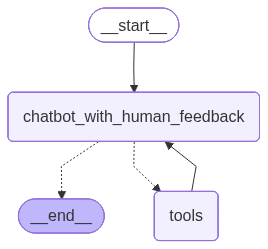

In [27]:
graph = graph.compile(checkpointer=memory)
graph

In [30]:
user_input = "Hi, I am looking for human expert on topic 'What is the recent AI news?'"
config = {
    "configurable": {"thread_id": "6"},
    "recursion_limit": 50  # Increase the recursion limit
}

events = graph.stream({"messages": user_input}, config, stream_mode="updates")
print(events)

<generator object Pregel.stream at 0x1293feac0>


GraphRecursionError: Recursion limit of 50 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [ ]:
for chunk in events:
    if "messages" in chunk:
        chunk["messages"][-1].pretty_print()

In [31]:
human_feedback = ("Sure, I can help you with that. The recent AI news includes advancements in natural language processing, "
                  "new AI models being released, and significant investments in AI research by major tech companies.")

human_command = Command(resume = {"data": human_feedback})
events = graph.stream(human_command, config, stream_mode="values")
print(events)

<generator object Pregel.stream at 0x12991ae40>


In [32]:
for chunk in events:
    if "messages" in chunk:
        chunk["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search

{"query": "AI latest news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.forbes.com/sites/lauraclaytonmcdonnell/2025/08/20/the-ai-tipping-point-is-coming-from-corporate-power-users/", "title": "The AI Tipping Point Is Coming From Corporate Power Users - Forbes", "score": 0.8367897272109985, "published_date": "Wed, 20 Aug 2025 20:53:26 GMT", "content": "Some of the most breakthrough real-world use cases for AI right now are coming from the corporate legal, tax and accounting, compliance, global trade, human resources other departments that handle complex, data-heavy information processing workloads. First, there is the current business environment, which I described in a recent article as the ‘age of uncertainty.’ This is an extraordinarily challenging time to be working in the legal, tax, compliance, or global trade function of a large cor